# Time series forecasting methods

In this notebook we will learn about basic approaches in time series forecasting:
* smoothing (moving average and exponetial)
* ARIMA
* Facebook Prophet

In [25]:
import copy
from datetime import timedelta, datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima.arima import auto_arima

from prophet import Prophet

### Loading data

Loads data from .csv file, changing column date to datetime type and aggregating the data. 

In [2]:
df = pd.read_csv('single_item_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['store_id', 'date'])
df_agg = df.groupby('date')['quantity'].sum()

## Average Smoothing

The basic idea of smoothing is to reduce noise. The simplest way of doing it is to simply calculate average value. 

In [3]:
avg = df_agg.mean()
avg

480.2864502833591

plotting average ...

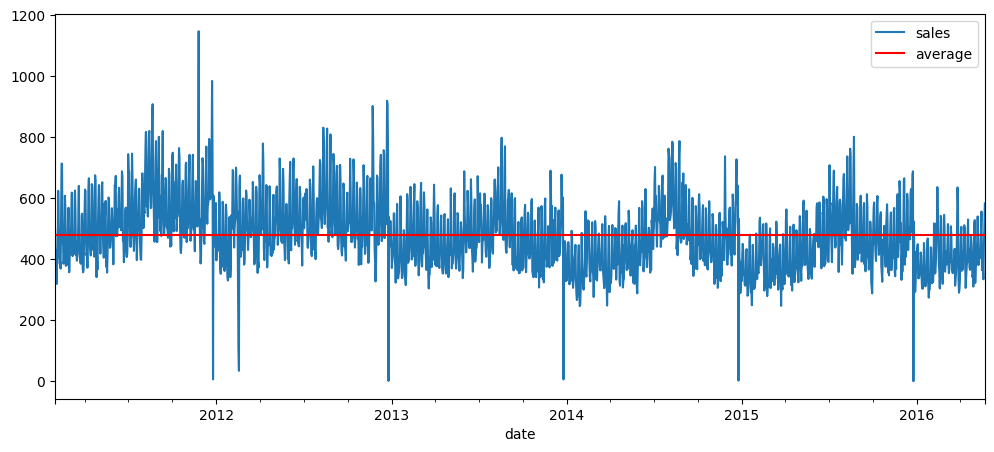

In [4]:
f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,1,1)
df_agg.plot(ax=ax, label='sales')
ax.axhline(avg, color='red', label='average')
ax.legend()

This can be used as a naive technique in time series forecasting: by forecasting constant value  ...

## Evaluation framework

We need evaluation framework to assess the performance of our time series forecasting model. It is always very important that evaluation framework is prepared in a way to mimic the use of the model in the real-world scenario. 

In the retail industry one of the main challenges is estimating demand in the upcoming days. We will demonstrate and evaluate it using of our selected "FOODS_3_586" item in 10 provided stores. To evaluate performance, we will use the last year as testing set, starting by computing projected sales for the last year (52 weeks) and the comparing it with the actual sales figures from the last year. 

We need to:
* split data into training and testing data
* define evaluation function (measures to estimate accuracy)
* implement walk-forward procedure (for 52 weeks with 1 week step)

### Splitting the data

In [5]:
# 1. prepare aggregated data
final_date = df_agg.index.max()
learn_to = final_date - timedelta(days=364)
train_agg = df_agg[df_agg.index <= learn_to]
test_agg = df_agg[df_agg.index > learn_to]
train_wf_agg, test_wf_agg = [], []
while learn_to <= final_date-timedelta(days=6):
    train_wf_agg.append(df_agg[df_agg.index <= learn_to])
    test_wf_agg.append(df_agg[(df_agg.index > learn_to) & (df_agg.index <= learn_to + timedelta(days=7))])
    learn_to += timedelta(days=7)
    
# 2. prepare data per store
learn_to = final_date - timedelta(days=364)
dt_index = df.index.get_level_values('date')
train = df[dt_index <= learn_to]
test = df[dt_index > learn_to]
train_wf, test_wf = [], []
while learn_to <= final_date-timedelta(days=6):
    train_wf.append(df[dt_index <= learn_to])
    test_wf.append(df[(dt_index > learn_to) & (dt_index <= learn_to + timedelta(days=7))])
    learn_to += timedelta(days=7)

### Evaluation function

We'll use this function to evaluate the quality of forecasts. We will test the method on all stores with two measures: WMAPE and WBIAS

$$ wMAPE = \frac{\sum_i\frac{ |y_i - \hat{y_i}|}{y_i}w_i}{\sum w_i} = \frac{\sum_i |y_i - \hat{y_i}|}{\sum y_i} $$

$$ wBIAS = \frac{\sum_i (y_i - \hat{y_i})}{\sum y_i} $$

In [6]:
def wMAPE(actual, forecast):
    return (forecast - actual).abs().sum() / actual.sum()

def wBIAS(actual, forecast):
    return (forecast - actual).sum() / actual.sum()

def evaluate(actual, forecast):
    print("wMAPE = {}".format(wMAPE(actual, forecast)[0]))
    print("wBIAS = {}".format(wBIAS(actual, forecast)[0]))

### Forecasting with the Walk-forward procedure

In [7]:
def forecast(method, training, testing):
    forecasts = []
    for train, test in zip(training, testing):
        method.fit(train)
        forecasts.append(method.forecast(test))
    forecasts = pd.concat(forecasts).sort_index()
    return forecasts

### A function for plotting forecasts

In [8]:
def plot_forecast(train, test, forecast, n=364):
    f = plt.figure(figsize=(12,5))
    ax = f.add_subplot(1,1,1)
    train.iloc[-n:].plot(ax=ax, color='blue', label='train data')
    test.plot(ax=ax, color='blue', linestyle='-.', label='test data')
    forecast.plot(ax=ax, color='red', label='forecasted data')
    ax.legend()

## Back to average smooting

### Example

In [9]:
train_0 = train_wf_agg[0]
test_0 = test_wf_agg[0]

In [12]:
avg = train_0.mean()
fc = pd.Series(avg, test_0.index)

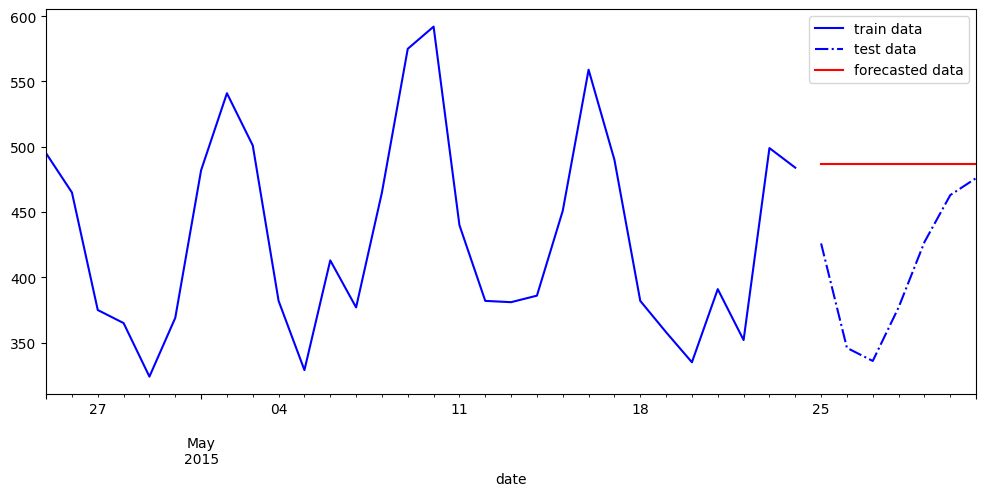

In [13]:
plot_forecast(train_0, test_0, fc, n=30)

### Class method ForecastAvg

In [155]:
class ForecastAvg:
    def fit(self, train):
        self.avg = train.mean()
        
    def forecast(self, test):
        return pd.Series(self.avg, index=test.index)

class ForecastGrp:
    def __init__(self, method):
        self.method = method
    
    def fit(self, train):
        gr_train = train.groupby('store_id')
        self.model_fit = {}
        for gr, gr_vals in gr_train:
            model = copy.deepcopy(self.method)
            model.fit(gr_vals.droplevel(level='store_id', axis=0)['quantity'])
            self.model_fit[gr] = model
            
    def forecast(self, test):
        gr_test = test.groupby('store_id')
        results = []
        for gr, gr_vals in gr_test:
            predictions = self.model_fit[gr].forecast(gr_vals.droplevel(level='store_id', axis=0)['quantity'])
            results.append(pd.Series(predictions.values, index=gr_vals.index, name='quantity'))
        return pd.concat(results).to_frame()

In [156]:
favg = forecast(ForecastAvg(), train_wf_agg, test_wf_agg)
favg

date
2015-05-25    486.744451
2015-05-26    486.744451
2015-05-27    486.744451
2015-05-28    486.744451
2015-05-29    486.744451
                 ...    
2016-05-18    480.463289
2016-05-19    480.463289
2016-05-20    480.463289
2016-05-21    480.463289
2016-05-22    480.463289
Length: 364, dtype: float64

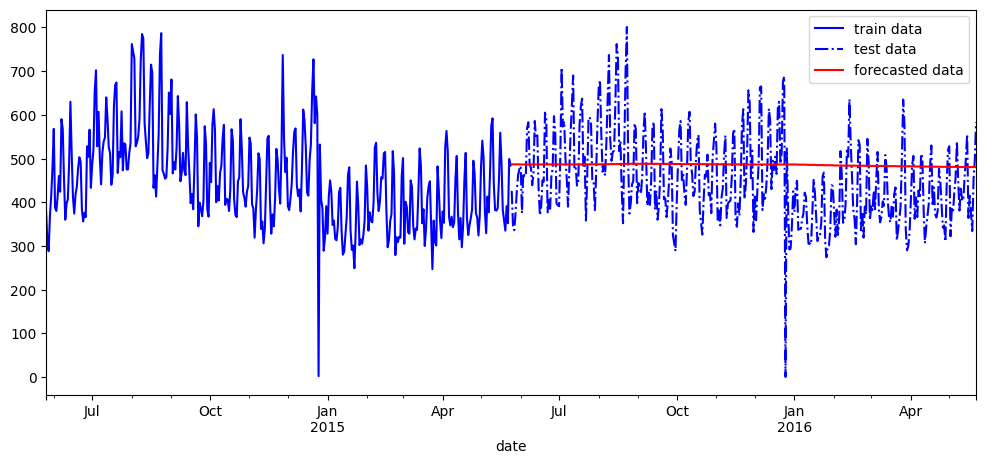

In [157]:
plot_forecast(train_agg, test_agg, favg)

In [158]:
avg_forecast = forecast(ForecastGrp(ForecastAvg()), train_wf, test_wf)
evaluate(test, avg_forecast)

wMAPE = 0.27334410241723234
wBIAS = 0.07308176118409065


## Moving average smoothing

Moving average smoothing is still a naive but an effective technique in time series forecasting. As always with smoothing its basic idea is to reduce noise. 

### Example

Moving average as smoothing ...

<Axes: xlabel='date'>

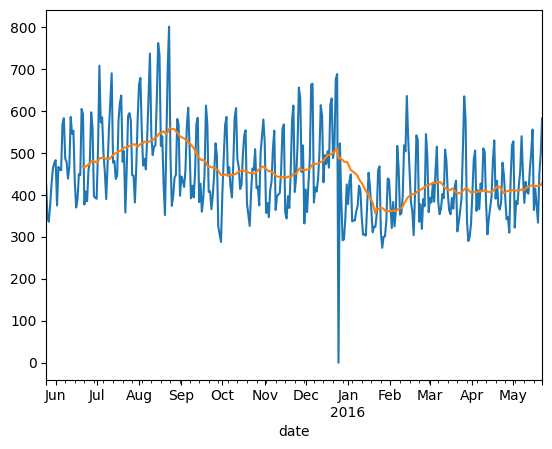

In [159]:
test_agg.plot()
test_agg.rolling(window=28).mean().plot()

Moving average as forecasting means to calculate mean on recent data. 

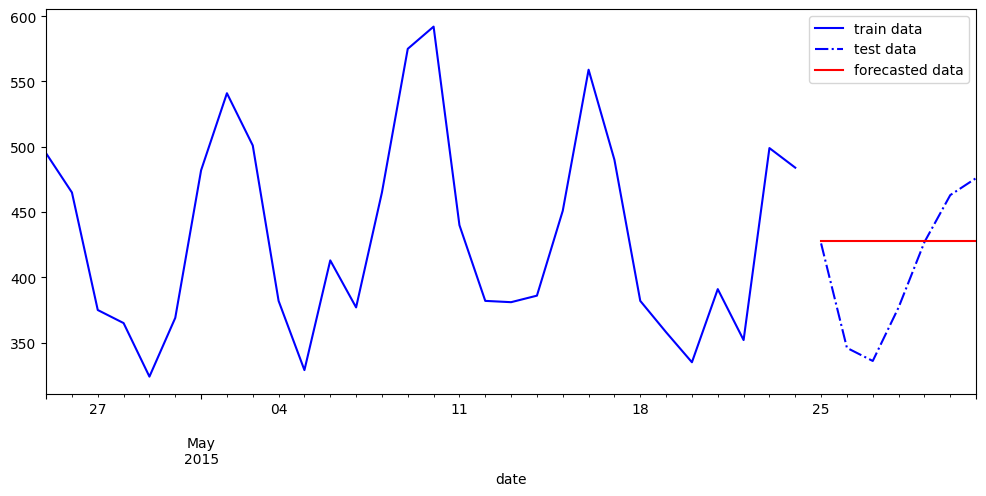

In [160]:
avg = train_0[-28:].mean()
fc = pd.Series(avg, test_0.index)
plot_forecast(train_0, test_0, fc, n=30)

### Class ForecastMAS

In [161]:
class ForecastMAS:
    def __init__(self, weeks):
        self.weeks = weeks
    
    def fit(self, train):
        self.avg = train[-7*self.weeks:].mean()
        
    def forecast(self, test):
        return pd.Series(self.avg, index=test.index)

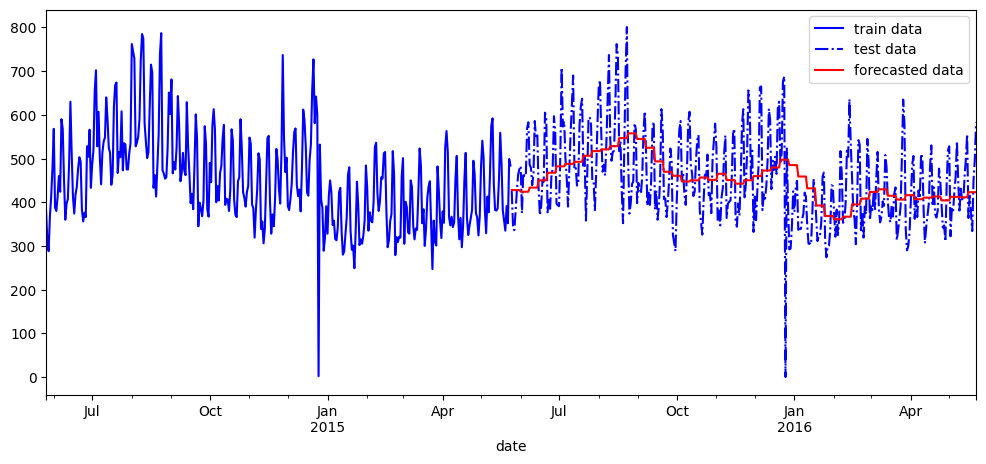

In [162]:
favg = forecast(ForecastMAS(4), train_wf_agg, test_wf_agg)
plot_forecast(train_agg, test_agg, favg)

In [163]:
favg = forecast(ForecastGrp(ForecastMAS(4)), train_wf, test_wf)
evaluate(test, favg)

wMAPE = 0.22592973413855333
wBIAS = -0.0008898202137998035


## Moving average with yearls seasonality

Basic idea: calculate correction factor for each week in one year.

### Example

In [164]:
train_agg.loc['2014-12-28':'2014-12-31']

date
2014-12-28    387
2014-12-29    289
2014-12-30    319
2014-12-31    391
Name: quantity, dtype: int64

In [165]:
def week_num(d):
    return np.minimum(d.isocalendar().week, 52)

<Axes: xlabel='week'>

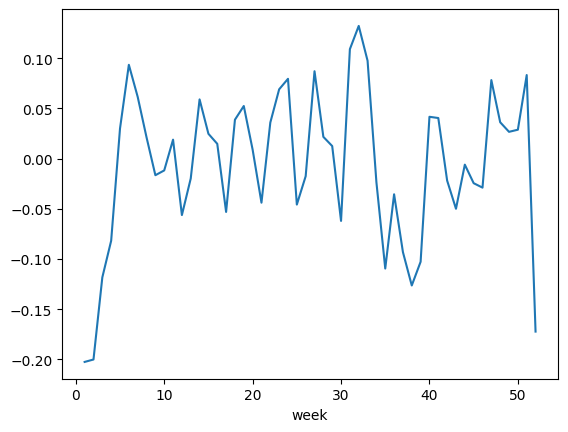

In [166]:
# calculate errors on train data
errors = (train_agg - train_agg.shift(1).rolling(28, center=False).mean())
# aggregate errors per week number
werrors = errors.groupby(week_num(errors.index)).sum()
sales = train_agg.groupby(week_num(train_agg.index)).sum()
(werrors / sales).plot()

### Class ForecastMAS_YS

In [169]:
class ForecastMAS_YS:
    def __init__(self, weeks):
        self.weeks = weeks
    
    def fit(self, train):
        self.avg = train[-7*self.weeks:].mean()
        
        # get seasonalities
        errors = (train_agg - train_agg.shift(1).rolling(28, center=False).mean())
        # aggregate errors per week number
        werrors = errors.groupby(week_num(errors.index)).sum()
        sales = train_agg.groupby(week_num(train_agg.index)).sum()
        self.factors = (sales + werrors) / (sales)
        #print(self.factors)
        
    def forecast(self, test):
        return pd.Series(self.avg, index=test.index) * self.factors[week_num(test.index)].values


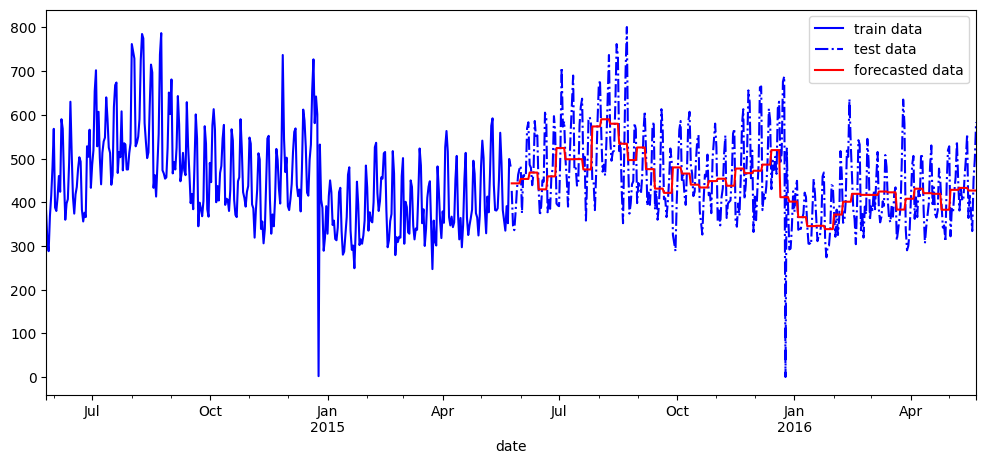

In [170]:
favg = forecast(ForecastMAS_YS(4), train_wf_agg, test_wf_agg)
plot_forecast(train_agg, test_agg, favg)

In [171]:
favg = forecast(ForecastGrp(ForecastMAS_YS(4)), train_wf, test_wf)
evaluate(test, favg)

wMAPE = 0.21908003045785868
wBIAS = -0.010553602846485599


## Moving average with weekly seasonality

We need to multiply our forecasts with another factor: day of week index

In [175]:
a = pd.merge(train_agg, train_agg.resample('W').mean(), how='left', on='date', suffixes=('', '_w')).bfill()
gr = a.groupby(a.index.dayofweek)
gr['quantity'].sum() / gr['quantity_w'].sum()

date
0    0.905744
1    0.857010
2    0.859978
3    0.899416
4    1.031471
5    1.233194
6    1.211169
dtype: float64

<Axes: xlabel='date'>

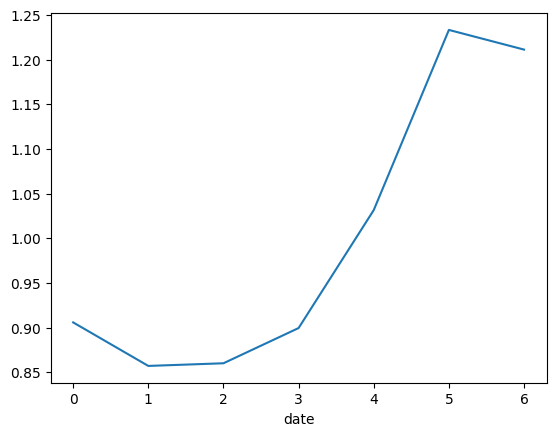

In [176]:
(gr['quantity'].sum() / gr['quantity_w'].sum()).plot()

In [183]:
class ForecastMAS_YS_WS:
    def __init__(self, weeks):
        self.weeks = weeks
    
    def fit(self, train):
        self.avg = train[-7*self.weeks:].mean()
        
        # get seasonalities
        errors = (train_agg - train_agg.shift(1).rolling(28, center=False).mean())
        # aggregate errors per week number
        werrors = errors.groupby(week_num(errors.index)).sum()
        sales = train_agg.groupby(week_num(train_agg.index)).sum()
        self.factors = (sales + werrors) / (sales)

        avg_weekly = pd.merge(train_agg, train_agg.resample('W').mean(), how='left', on='date', suffixes=('', '_w')).bfill()
        gr = avg_weekly.groupby(avg_weekly.index.dayofweek)
        self.daily_factors = gr['quantity'].sum() / gr['quantity_w'].sum()

        
    def forecast(self, test):
        return pd.Series(self.avg, index=test.index) * self.factors[week_num(test.index)].values * self.daily_factors[test.index.dayofweek].values

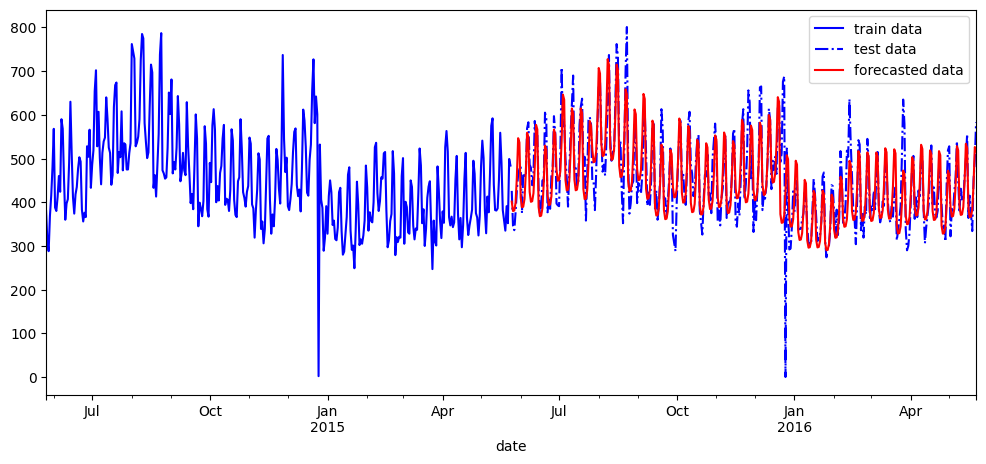

In [184]:
favg = forecast(ForecastMA_YS_WS(4), train_wf_agg, test_wf_agg)
plot_forecast(train_agg, test_agg, favg)

In [185]:
favg = forecast(ForecastGrp(ForecastMAS_YS_WS(4)), train_wf, test_wf)
evaluate(test, favg)

wMAPE = 0.18193136169226276
wBIAS = -0.010838936558010456


Overview of results

| Method | wMAPE | wBIAS |
| :------| :----- | :---- |
| Average | 0.27 | 0.07 |
| Moving average | 0.23 | 0.0 |
| Moving average (yearly season) | 0.22 | -0.01 |
| Moving average (yearly+daily season) | 0.18 | -0.01 |

## 3. Exponential Smoothing
The idea of exponential smoothing is to weight observations differently. While moving average smoothing weights all the same, here recent observations are weighted moreso than more distant ones. This makes sense when behaviour of time series is more similar to recent behaviour.


### Example

Let's make a simple example. 

Say we have the values [1, 2, 4, 9, 16, 25, 36, ...]. You get the idea, the numbers are increasing quadratically. 

The general formula for exponential smoothing is: 
$S_{t} = \alpha*X_{t} + (1-\alpha)*\alpha*X_{t-1} + (1-\alpha)*\alpha^2*X_{t-2} + \ldots$


In [187]:
values = pd.Series([i*i for i in range(100)])

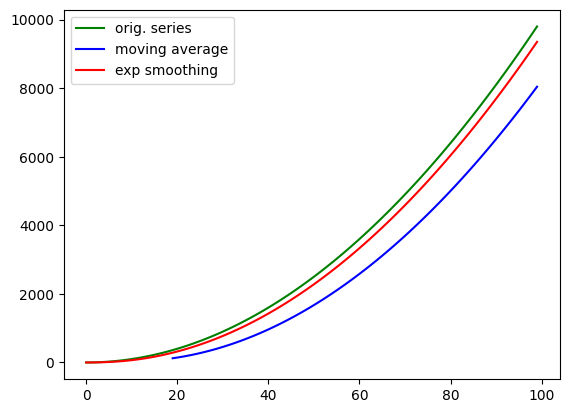

In [194]:
values.plot(label='orig. series', color='green')
values.rolling(window=20).mean().plot(label='moving average', color='blue')
values.ewm(alpha=0.3).mean().plot(label='exp smoothing', color='red')
plt.legend()

In [198]:
values = pd.Series([np.sin(x*2*np.pi/360) for x in range(360)])

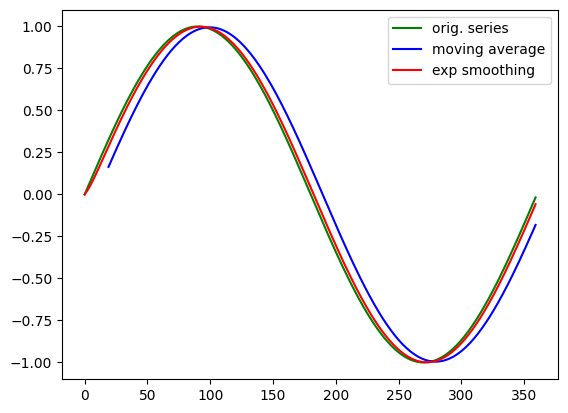

In [203]:
values.plot(label='orig. series', color='green')
values.rolling(window=20).mean().plot(label='moving average', color='blue')
values.ewm(alpha=0.3).mean().plot(label='exp smoothing', color='red')
plt.legend()

### A. Single exponential smoothing

We will now use exponential smoothing for forecasts. The simplest form is use exponential smoothing directly:

$S_{t} = \alpha*X_{t} + (1-\alpha)*S_{t-1}$ -- smoothing the value of the series

$\hat{X_{t+1}} = S_t$ -- forecast

In [204]:
single = SimpleExpSmoothing(train_0.values).fit(optimized=True)

In [206]:
single_preds = single.forecast(len(test_0))

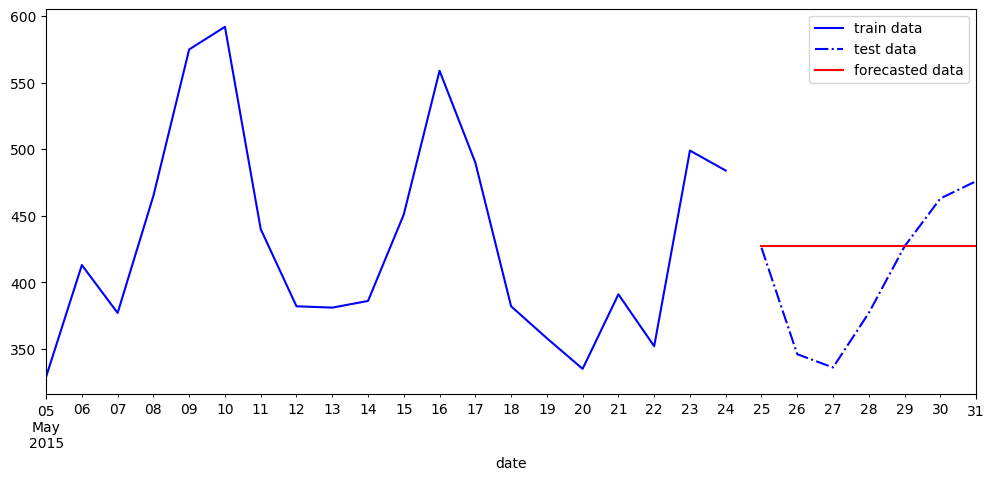

In [207]:
plot_forecast(train_0, test_0, pd.Series(single_preds, index=test_0.index), n=20)

In [208]:
class ForecastSingle:
    
    def fit(self, train):
        self.single_smooth = SimpleExpSmoothing(train.values).fit(optimized=True)
        
    def forecast(self, test):
        single_preds = self.single_smooth.forecast(len(test))
        return pd.Series(single_preds, index=test.index)

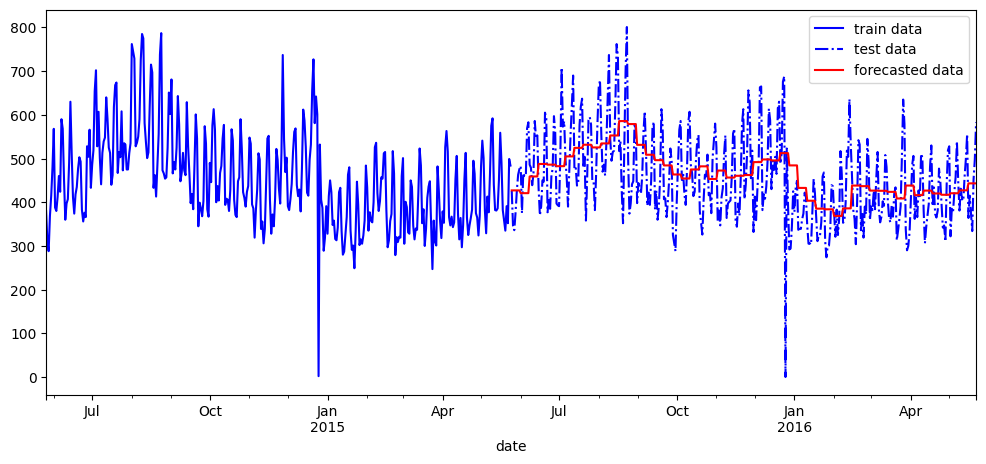

In [209]:
favg = forecast(ForecastSingle(), train_wf_agg, test_wf_agg)
plot_forecast(train_agg, test_agg, favg)

In [210]:
favg = forecast(ForecastGrp(ForecastSingle()), train_wf, test_wf)
evaluate(test, favg)

wMAPE = 0.2250256119624034
wBIAS = 0.026760719831067793


Overview of results

| Method | wMAPE | wBIAS |
| :------| :----- | :---- |
| Average | 0.27 | 0.07 |
| Moving average | 0.23 | 0.0 |
| Moving average (yearly season) | 0.22 | -0.01 |
| Moving average (yearly+daily season) | 0.18 | -0.01 |
| Single exponential smoothing | 0.23 | 0.03 |

### B. Double exponential smoothing (Holt)

$S_{t} = \alpha*X_{t} + (1-\alpha)*(S_{t-1} + b_{t-1})$ -- smoothing the value of the series

$b_{t} = \beta*(S_t - S_{t-1}) + (1-\beta)*(b_t - b_{t-1})$ -- smoothing the trend of the series

$\hat{X_{t+1}} = S_t + b_t$ -- forecast

In [212]:
double_smooth = Holt(train_0.values).fit(optimized=True)
double_preds = double_smooth.forecast(len(test_0))

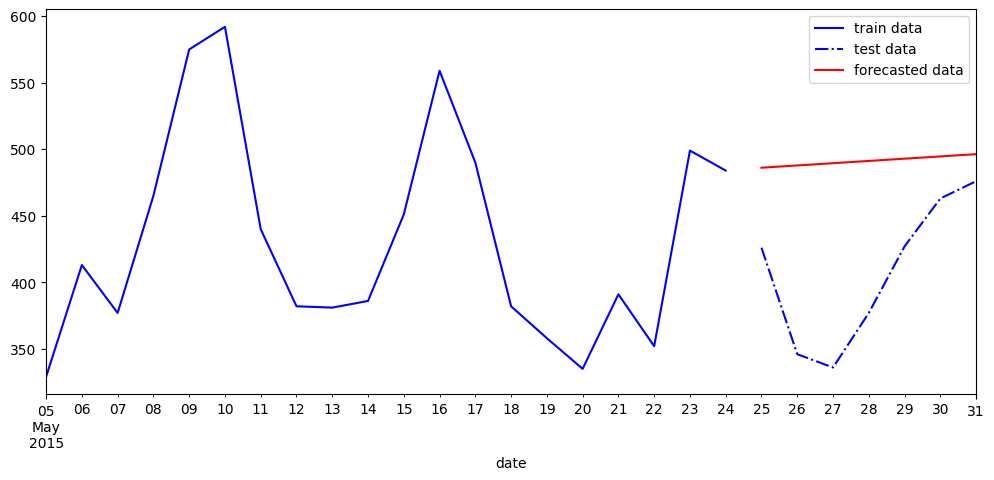

In [213]:
plot_forecast(train_0, test_0, pd.Series(double_preds, index=test_0.index), n=20)

In [214]:
class ForecastDouble:
    def fit(self, train):
        self.single_smooth = Holt(train.values).fit(optimized=True)
        
    def forecast(self, test):
        single_preds = self.single_smooth.forecast(len(test))
        return pd.Series(single_preds, index=test.index)

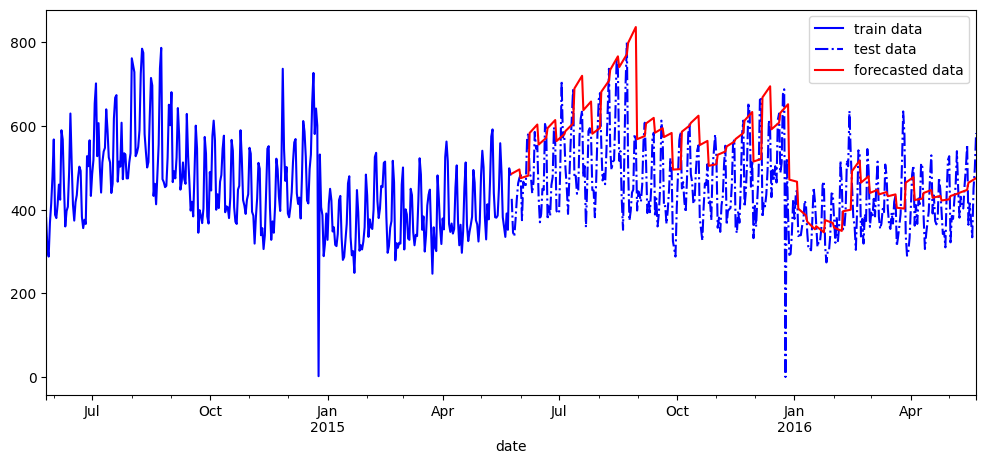

In [215]:
favg = forecast(ForecastDouble(), train_wf_agg, test_wf_agg)
plot_forecast(train_agg, test_agg, favg)

In [216]:
favg = forecast(ForecastGrp(ForecastDouble()), train_wf, test_wf)
evaluate(test, favg)

wMAPE = 0.23743014992367073
wBIAS = 0.06770156336726664


Overview of results

| Method | wMAPE | wBIAS |
| :------| :----- | :---- |
| Average | 0.27 | 0.07 |
| Moving average | 0.23 | 0.0 |
| Moving average (yearly season) | 0.22 | -0.01 |
| Moving average (yearly+daily season) | 0.18 | -0.01 |
| Single exponential smoothing | 0.23 | 0.03 |
| Double exponential smoothing | 0.24 | 0.07 |

### Triple exponential smoothing (Holt-Winters)

$S_{t} = \alpha*(X_{t} - c_{t-L}) + (1-\alpha)*(S_{t-1} + b_{t-1})$ -- smoothing the value of the series

$b_{t} = \beta*(S_t - S_{t-1}) + (1-\beta)*(b_t - b_{t-1})$ -- smoothing the trend of the series

$c_{t} = \gamma*(X_{t} - S_{t-1} - b_{t-1}) + (1-\gamma)*c_{T-L}$ -- smoothing the seasonality of the series

$\hat{X_{t+m}} = (S_t + m*b_t) * c_{T-L+((m-1) \% L)}$ -- forecast

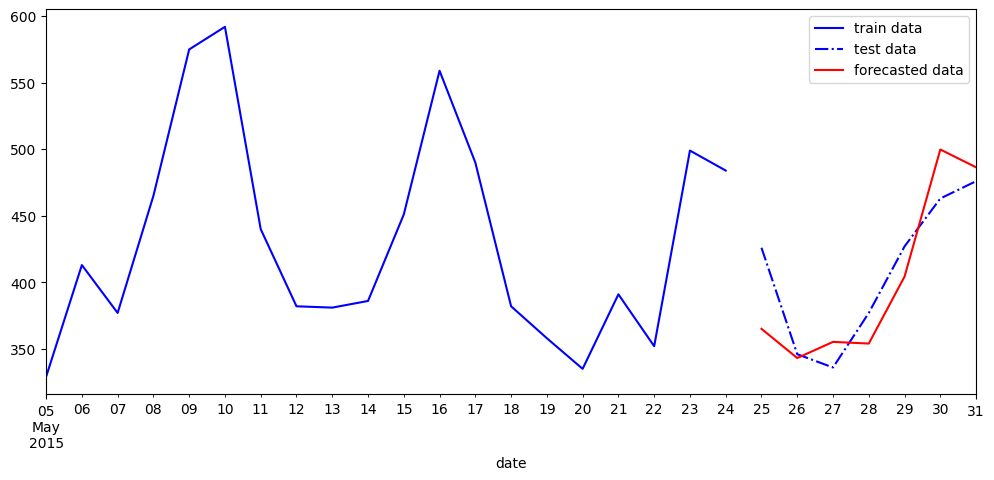

In [217]:
triple_smooth = ExponentialSmoothing(train_0.values,
                              trend="additive",
                              seasonal="multiplicative",
                              seasonal_periods=7).fit(optimized=True)
triple_preds = triple_smooth.forecast(len(test_0))
plot_forecast(train_0, test_0, pd.Series(triple_preds, index=test_0.index), n=20)

In [220]:
class ForecastTriple:
   
    def fit(self, train):
        self.triple_smooth = ExponentialSmoothing(train.values+1,
                              trend="additive",
                              seasonal="multiplicative",
                              seasonal_periods=7).fit(optimized=True)
        
    def forecast(self, test):
        single_preds = self.triple_smooth.forecast(len(test))-1
        return pd.Series(single_preds, index=test.index)

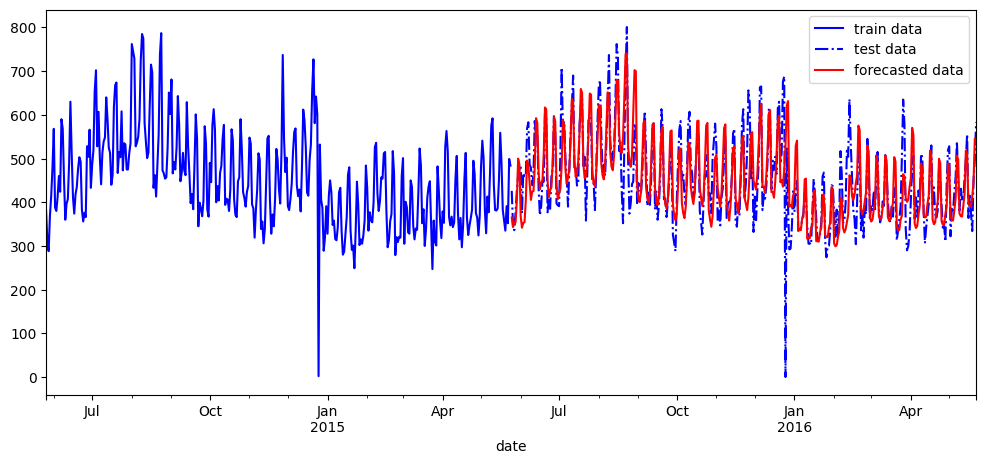

In [221]:
favg = forecast(ForecastTriple(), train_wf_agg, test_wf_agg)
plot_forecast(train_agg, test_agg, favg)

In [222]:
favg = forecast(ForecastGrp(ForecastTriple()), train_wf, test_wf)
evaluate(test, favg)

wMAPE = 0.1824780387517839
wBIAS = -0.0022496561370680926


Overview of results

| Method | wMAPE | wBIAS |
| :------| :----- | :---- |
| Average | 0.27 | 0.07 |
| Moving average | 0.23 | 0.0 |
| Moving average (yearly season) | 0.22 | -0.01 |
| Moving average (yearly+daily season) | 0.18 | -0.01 |
| Single exponential smoothing | 0.23 | 0.03 |
| Double exponential smoothing | 0.24 | 0.07 |
| Triple exponential smoothing | 0.18 | 0.0 |

## ARIMA

The method was proposed by George Box and Gwilym Jenkins in their seminal 1970 textbook Time Series Analysis: Forecasting and Control. The approach starts with the assumption that the process that generated the time series can be approximated using an **ARMA model if it is stationary** or an **ARIMA model if it is non-stationary**.

- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I**: Integrated. The use of differencing of raw observations (i.e. subtracting an observation
from an observation at the previous time step) in order to make the time series stationary.
- **MA**: Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.

A standard notation is `ARIMA(p,d,q)` where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

- **p**: The number of lag observations included in the model, also called the **lag order**.
- **d**: The number of times that the raw observations are differenced, also called the **degree of differencing**.
- **q**: The size of the moving average window, also called the **order of moving average**.

When we work with SARIMA models 'S' refers to 'seasonal' and we have the additional standard inputs - seasonal order (p, d, q):
- **p** is number of AR terms in regards to seasonal lag
- **d** is number of times that we would difference our seasonal lag (as seen above)
- **q** is number of MA terms in regards to seasonal lag
- **s** is number of periods in a season

An iterative approach consists of the following three steps:
1. **Identification**. Use the data and all related information to help select a sub-class ofmodel that may best summarize the data.
2. **Estimation**. Use the data to train the parameters of the model (i.e. the coeficients).
3. **Diagnostic Checking**. Evaluate the fitted model in the context of the available data and check for areas where the model may be improved.

When to use SARIMA?

Algorithm | Trend | Seasonal | Correlations 
---|---|---|--- 
SARIMAX | X |X|X
MA Smoothing |X||
MA Smoothing + Seasonal Adjustment |X|X|
Simple Exponential Smoothing |X||
Holt's Exponential Smoothing |X||
Holt-Winters |X|X|

### 1. Identification

##### Differencing

- **Unit Root Tests**: Use unit root statistical tests on the time series to determine whether or not it is stationary. Repeat after each round of differencing.
- **Avoid over differencing**: Differencing the time series more than is required can result in the addition of extra serial correlation and additional complexity.

##### Configuring AR and MA

- **Autocorrelation Function (ACF).** The plot summarizes the correlation of an observation with lag values. The x-axis shows the lag and the y-axis shows the correlation coeficient between -1 and 1 for negative and positive correlation.
- **Partial Autocorrelation Function (PACF).** The plot summarizes the correlations for an observation with lag values that is not accounted for by prior lagged observations.

Both plots are drawn as bar charts showing the 95% and 99% confidence intervals as horizontal lines. Bars that cross these confidence intervals are therefore more significant and worth noting. Some useful patterns you may observe on these plots are:
- The model is **AR** if the *ACF gradually decreases after a lag* and has a *hard cut-off in the PACF after a lag*. This lag is taken as the value for **p**.
- The model is **MA** if the *PACF gradually decreases after a lag* and has a *hard cut-off in the ACF after the lag*. This lag value is taken as the value for **q**.
- The model is a mix of **AR and MA** if both the *ACF and PACF gradually decrease*.

### 2. Estimation

Estimation involves using numerical methods to minimize a loss or error term. Optimization problem to be solved by ARMA and ARIMA models.

### 3. Diagnostic Checking

The idea of diagnostic checking is to look for evidence that the model is not a good fit for the data. Two useful areas to investigate diagnostics are:
- **overfitting**: model is more complex than it needs to be and captures random noise in the training data,
- **residual errors**: a review of the distribution of errors (using density plots, histograms, and Q-Q plots) can help tease out bias in the model.

The errors from an ideal model would resemble white noise, that is a Gaussian distribution with a mean of zero and a symmetrical variance. Additionally, an ideal model would leave no temporal structure in the time series of forecast residuals. These can be checked by creating ACF and PACF plots of the residual error time series.

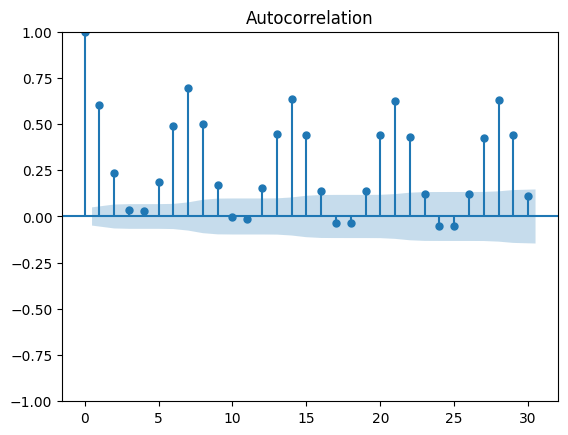

In [233]:
# Autocorrelation Function (ACF)
plot_acf(train_agg, lags=30);

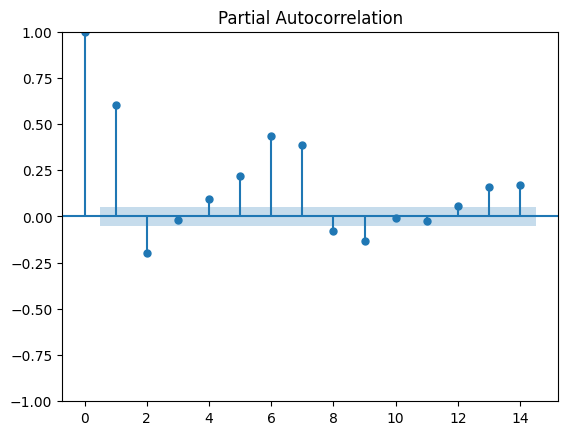

In [234]:
plot_pacf(train_agg, lags=14);

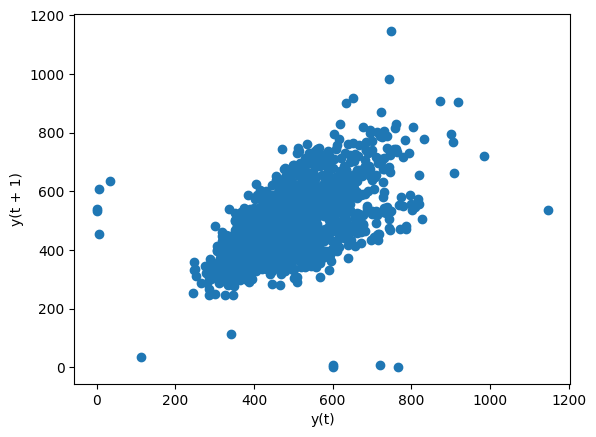

In [235]:
# lag plot
pd.plotting.lag_plot(train_agg);

### Autoregression Model

**Autocorrelation:** a variable's correlation with itself at different lags.

AR model is a linear regression model that uses lagged variables as input variables.

This is the first order or **AR(1)** formula you should know: $y_t = \beta_0 + \beta_1y_{t-1}+\epsilon_t$

The $\beta$'s are just like those in linear regression and $\epsilon$ is irreducible error.

A second order or **AR(2)** would look like this: $y_t = \beta_0 + \beta_1y_{t-1}+\beta_2y_{t-2}+\epsilon_t$


The ```Statsmodels``` library provides an autoregression model that automatically selects an appropriate lag value
using statistical tests and trains a linear regression model. It is provided in the ```AutoReg``` class.

In [236]:
lags=[1,2,3,4,5,6,7,8,9,13,14,21,28,363,364,365]

# train autoregression
model = AutoReg(train_0.values, lags=lags)
model_fit = model.fit()

In [228]:
print('Coefficients: %s' % model_fit.params)

Coefficients: [-2.52986479e+01  3.16672061e-01  1.50262636e-02  2.60600928e-02
  2.31777001e-02 -2.21538325e-02  1.40556657e-02  2.17224942e-01
 -1.68785533e-02 -1.25577220e-01  1.89561596e-02  8.86265983e-02
  8.98269233e-02  8.00435615e-02  1.14264752e-01  1.77919037e-01
  1.94676529e-02]


In [237]:
predictions = model_fit.predict(start=len(train_0), end=len(train_0)+len(test_0)-1, dynamic=True)

In [238]:
predictions

array([379.35352027, 324.40731824, 327.32185435, 357.38908694,
       400.91281115, 486.99805147, 501.18576322])

In [239]:
predictions = pd.Series(predictions, test_0.index)

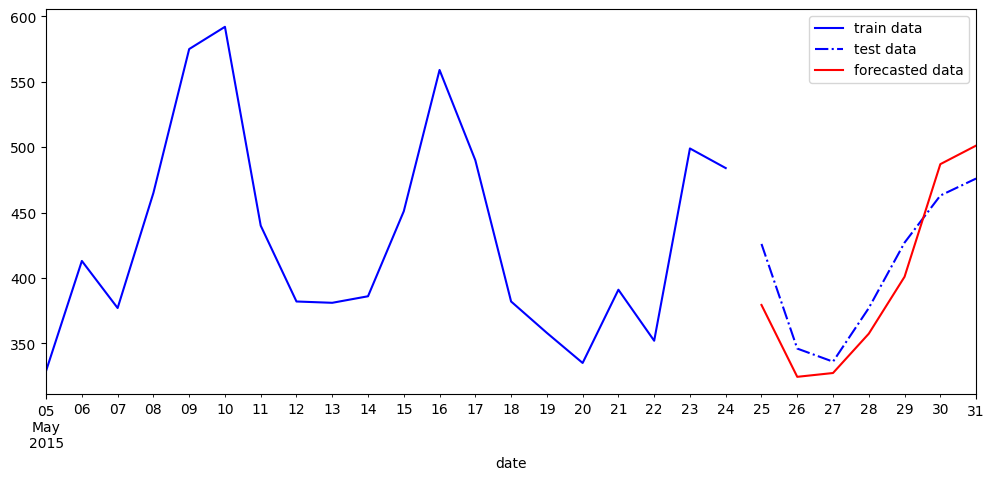

In [240]:
plot_forecast(train_0, test_0, pd.Series(predictions, index=test_0.index), n=20)

### Class ForecastAR

In [241]:
class ForecastAR:
    def __init__(self):
        self.lags = [1,2,3,4,5,6,7,8,9,13,14,21,28,363,364,365]
    
    def fit(self, train):
        model = AutoReg(train.values, lags=lags)
        self.model_fit = model.fit()
        self.len_train = len(train)
        
    def forecast(self, test):
        predictions = self.model_fit.predict(start=self.len_train, end=self.len_train+len(test)-1, dynamic=True)
        predictions = pd.Series(predictions, test.index)
        return predictions

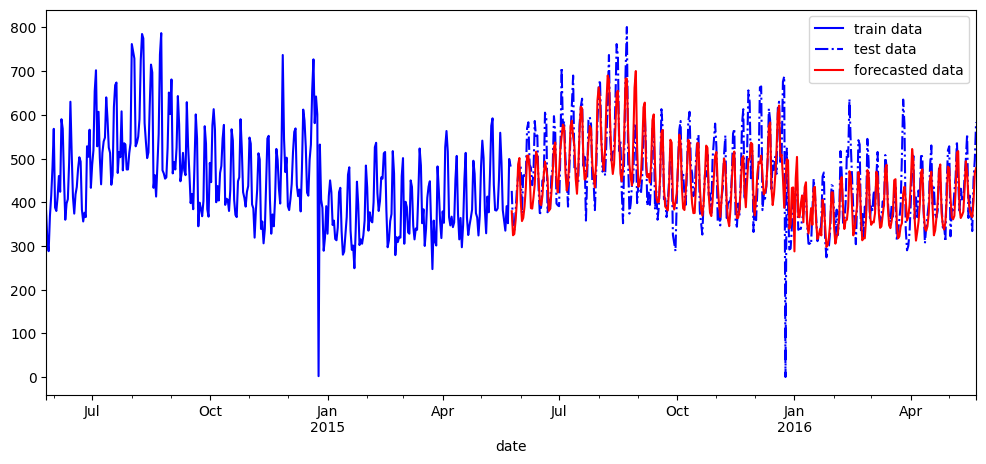

In [242]:
favg = forecast(ForecastAR(), train_wf_agg, test_wf_agg)
plot_forecast(train_agg, test_agg, favg)

In [244]:
favg = forecast(ForecastGrp(ForecastAR()), train_wf, test_wf)
evaluate(test, favg)

wMAPE = 0.1869276409700126
wBIAS = -0.001249398278173842


Overview of results

| Method | wMAPE | wBIAS |
| :------| :----- | :---- |
| Average | 0.27 | 0.07 |
| Moving average | 0.23 | 0.0 |
| Moving average (yearly season) | 0.22 | -0.01 |
| Moving average (yearly+daily season) | 0.18 | -0.01 |
| Single exponential smoothing | 0.23 | 0.03 |
| Double exponential smoothing | 0.24 | 0.07 |
| Triple exponential smoothing | 0.18 | 0.0 |
| AutoRegressive Model | 0.19 | 0.0 |

### Moving average modeling

The difference between what was expected and what was predicted is called the **residual error**. The residual errors from forecasts on a time series provide another source of information that we can model. Residual errors themselves form a time series that can have temporal structure.

A simple autoregression model of this structure can be used to **predict the forecast error**, which
in turn can be used to **correct forecasts**. This type of model is called a **moving average model**,
the same name but **very different from moving average smoothing**.

## ARIMA Model for Forecasting

### Example

In [246]:
# fit model
model = sm.tsa.SARIMAX(train_0.values, order=(5,1,0))
model_fit = model.fit()

In [247]:
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1577
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -9186.745
Date:                Sun, 21 May 2023   AIC                          18385.490
Time:                        17:53:20   BIC                          18417.666
Sample:                             0   HQIC                         18397.447
                               - 1577                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3501      0.011    -30.539      0.000      -0.373      -0.328
ar.L2         -0.4509      0.015    -30.938      0.000      -0.479      -0.422
ar.L3         -0.4522      0.018    -25.497      0.0

In [248]:
n_forecast = len(test_0)  # Specify the number of values to forecast ahead
predictions = model_fit.forecast(steps=n_forecast)

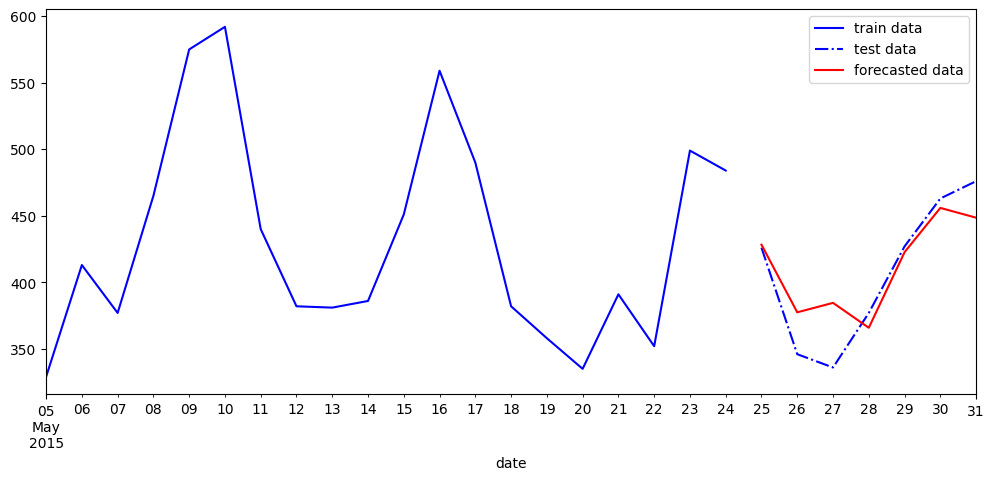

In [249]:
plot_forecast(train_0, test_0, pd.Series(predictions, index=test_0.index), n=20)

### Automatically determining parameters p, q, ...

In [250]:
auto_model = auto_arima(train_agg.values, start_p=0, start_q=0,
                            max_p=7, max_q=3, m=7,
                            start_P=0, seasonal=True,
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=18890.920, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=19163.622, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=18584.064, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=18697.291, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=19161.622, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=19163.215, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=18396.969, Time=0.96 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=18555.925, Time=0.38 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=18318.774, Time=1.23 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=18524.188, Time=0.47 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.05 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=1

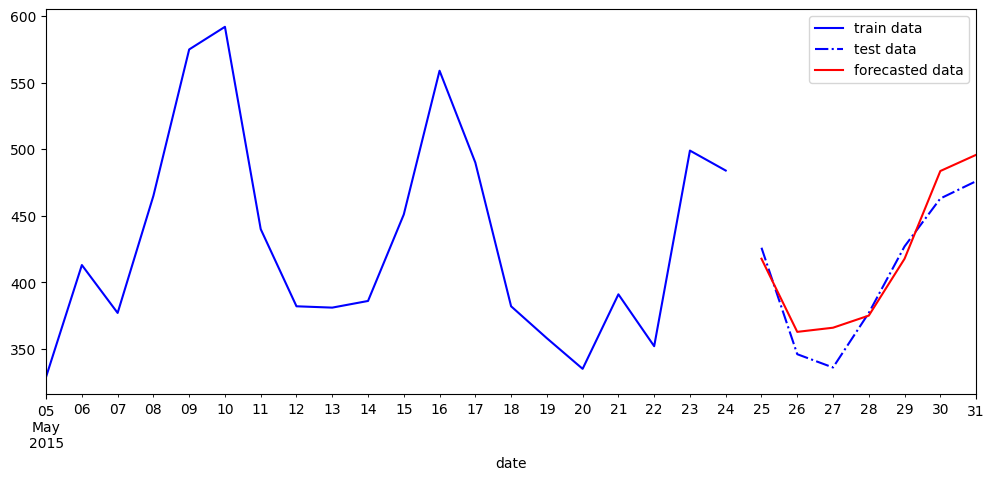

In [251]:
model = sm.tsa.SARIMAX(train_0.values, order=(6,1,0), seasonal_order=(2,0,0,7))
model_fit = model.fit(maxiter=1000)
n_forecast = len(test_0)  # Specify the number of values to forecast ahead
predictions = model_fit.forecast(steps=n_forecast)
plot_forecast(train_0, test_0, pd.Series(predictions, index=test_0.index), n=20)

### Class ForecastARIMA

In [258]:
class ForecastARIMA:
   
    def fit(self, train):
        model = sm.tsa.SARIMAX(train.values, order=(6,1,0), seasonal_order=(2,0,0,7))
        model_fit = model.fit(maxiter=1000)
        self.model_fit = model.fit()
        
    def forecast(self, test):
        predictions = self.model_fit.forecast(steps=len(test))
        predictions = pd.Series(predictions, test.index)
        return predictions

C:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

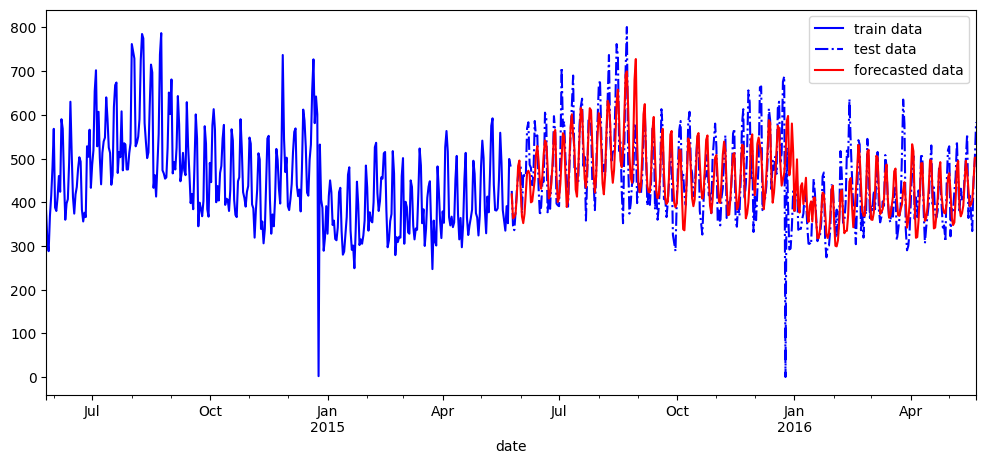

In [259]:
favg = forecast(ForecastARIMA(), train_wf_agg, test_wf_agg)
plot_forecast(train_agg, test_agg, favg)

In [261]:
favg = forecast(ForecastGrp(ForecastARIMA()), train_wf, test_wf)
evaluate(test, favg)

C:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Martin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

wMAPE = 0.19297512716971402
wBIAS = 0.004695140179781133


Overview of results

| Method | wMAPE | wBIAS |
| :------| :----- | :---- |
| Average | 0.27 | 0.07 |
| Moving average | 0.23 | 0.0 |
| Moving average (yearly season) | 0.22 | -0.01 |
| Moving average (yearly+daily season) | 0.18 | -0.01 |
| Single exponential smoothing | 0.23 | 0.03 |
| Double exponential smoothing | 0.24 | 0.07 |
| Triple exponential smoothing | 0.18 | 0.0 |
| AutoRegressive Model | 0.19 | 0.0 |
| SARIMA | 0.19 | 0.0 |

## Predicting with Facebook Prophet

From site (https://facebook.github.io/prophet/):
> Prophet is a forecasting procedure implemented in R and Python. It is fast and provides completly automated forecasts that can be tuned by hand by data scientists and analysts. 
> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

Prophet is an general additive model including state of the art time-series forecasting mechanisms: 

$y_t = g(t) + s(t) + h(t) + \epsilon_t$

Here g(t) is the trend function which models non-periodic changes in the value of the time series, s(t) represents periodic changes (e.g., weekly and yearly seasonality), and h(t) represents the effects of holidays (added as simple dummy variables).


Prophet was originally designed to address challenging at forecasting at Facebook. The primary motivations were:

- Flexibility and ease of use
- Large datasets
- Capturing multiple seasonalities (modeled using Fourier series):
    - Hourly, daily, or weekly observations with at least a few months (preferably a year) of history
    - Strong multiple “human-scale” seasonalities: day of week and time of year
    - Important holidays that occur at irregular intervals that are known in advance
- Handling outliers, irregularities, missing data (real-world data is often scarce, contains many ooutliers and missing values)
- Capturing trend changes (linear and non-linear), using piecewise linear or logistic growth
- Transparency and interpretability

### A simple example

Prepare data for Prophet: we need a data frame with columns ds and y.

In [263]:
train_agg_pr = train_0.reset_index()
train_agg_pr.head()

,date,quantity
0,2011-01-29,516
1,2011-01-30,479
2,2011-01-31,328
3,2011-02-01,376
4,2011-02-02,319


In [264]:
train_agg_pr.columns = ['ds', 'y']

In [265]:
model = Prophet()
model.fit(train_agg_pr)

20:14:19 - cmdstanpy - INFO - Chain [1] start processing
20:14:19 - cmdstanpy - INFO - Chain [1] done processing


In [266]:
fdata = model.make_future_dataframe(periods=7)
fc_prophet = model.predict(fdata)
fc_prophet.tail(7)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1577,2015-05-25,438.437925,295.758680,456.424874,438.437925,438.437925,-62.061674,-62.061674,-62.061674,-45.854532,-45.854532,-45.854532,-16.207142,-16.207142,-16.207142,0.0,0.0,0.0,376.376251
1578,2015-05-26,438.392347,267.062907,433.352197,438.392347,438.392347,-85.125537,-85.125537,-85.125537,-69.561902,-69.561902,-69.561902,-15.563635,-15.563635,-15.563635,0.0,0.0,0.0,353.266810
1579,2015-05-27,438.346769,277.937103,437.592659,438.346769,438.346769,-83.011441,-83.011441,-83.011441,-68.101927,-68.101927,-68.101927,-14.909514,-14.909514,-14.909514,0.0,0.0,0.0,355.335327
1580,2015-05-28,438.301190,301.107126,453.084081,438.301190,438.301190,-63.123717,-63.123717,-63.123717,-48.888111,-48.888111,-48.888111,-14.235606,-14.235606,-14.235606,0.0,0.0,0.0,375.177474
1581,2015-05-29,438.255612,358.254340,520.583658,438.255612,438.255612,1.875926,1.875926,1.875926,15.407905,15.407905,15.407905,-13.531979,-13.531979,-13.531979,0.0,0.0,0.0,440.131538
1582,2015-05-30,438.210034,458.598219,626.111948,438.210034,438.210034,101.069096,101.069096,101.069096,113.857365,113.857365,113.857365,-12.788269,-12.788269,-12.788269,0.0,0.0,0.0,539.279130
1583,2015-05-31,438.164455,445.583597,611.153686,438.164455,438.164455,91.147182,91.147182,91.147182,103.141202,103.141202,103.141202,-11.994020,-11.994020,-11.994020,0.0,0.0,0.0,529.311637


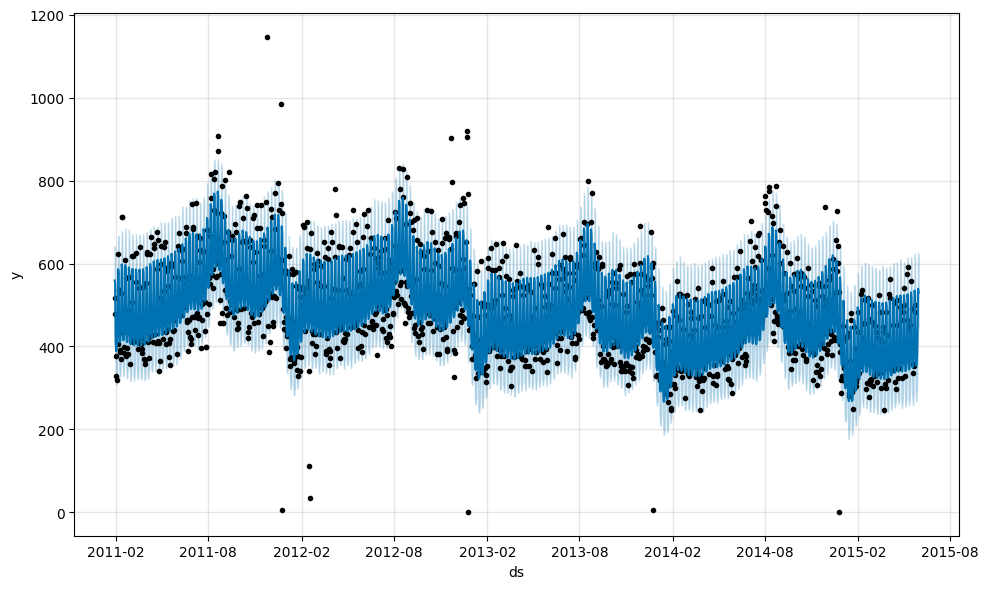

In [267]:
model.plot(fc_prophet);

In [268]:
fc_prophet = fc_prophet.tail(7)[['ds','yhat_lower','yhat_upper','yhat']].rename(columns={'ds':'date', 'yhat':'quantity'}).set_index('date')
fc_prophet                                                                            

,yhat_lower,yhat_upper,quantity
date,,,
2015-05-25,295.758680,456.424874,376.376251
2015-05-26,267.062907,433.352197,353.266810
2015-05-27,277.937103,437.592659,355.335327
2015-05-28,301.107126,453.084081,375.177474
2015-05-29,358.254340,520.583658,440.131538
2015-05-30,458.598219,626.111948,539.279130
2015-05-31,445.583597,611.153686,529.311637


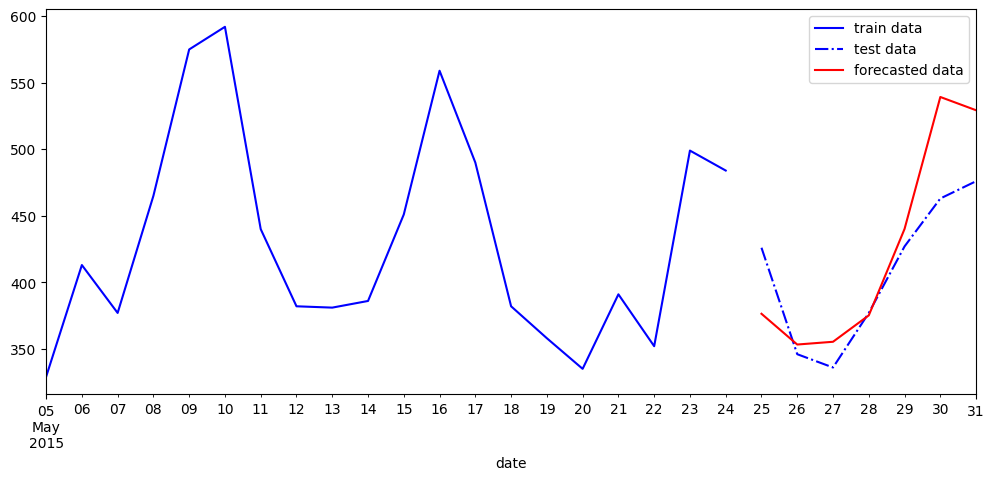

In [270]:
plot_forecast(train_0, test_0, pd.Series(fc_prophet['quantity'], index=test_0.index), n=20)

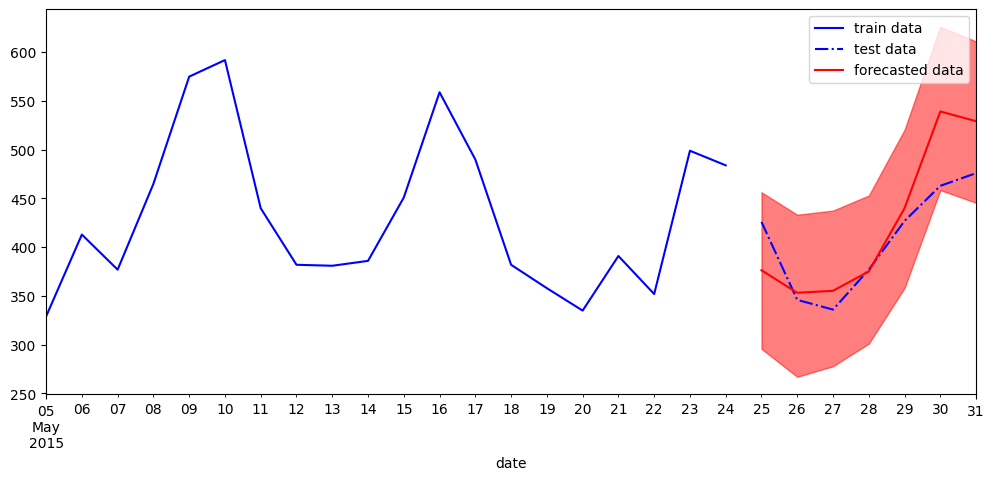

In [271]:
fplot = pd.DataFrame(fc_prophet, index=test_0.index)
n = 20

f = plt.figure(figsize=(12,5))
ax = f.add_subplot(1,1,1)
train_wf_agg[0].iloc[-n:].plot(ax=ax, color='blue', label='train data')
test_wf_agg[0].plot(ax=ax, color='blue', linestyle='-.', label='test data')
fplot['quantity'].plot(ax=ax, color='red', label='forecasted data')
ax.fill_between(fplot.index, fplot['yhat_lower'], fplot['yhat_upper'], color='red', alpha=0.5)
ax.legend()

### class ForecastProphet

In [272]:
class ForecastProphet:
    
    def fit(self, train):
        self.model = Prophet()
        train_pr = train.reset_index()
        train_pr.columns = ['ds', 'y']
        self.model.fit(train_pr)
        
    def forecast(self, test):
        fdata = self.model.make_future_dataframe(periods=len(test))
        fc_prophet = self.model.predict(fdata)
        return pd.Series(fc_prophet.tail(len(test))['yhat'].values, test.index)

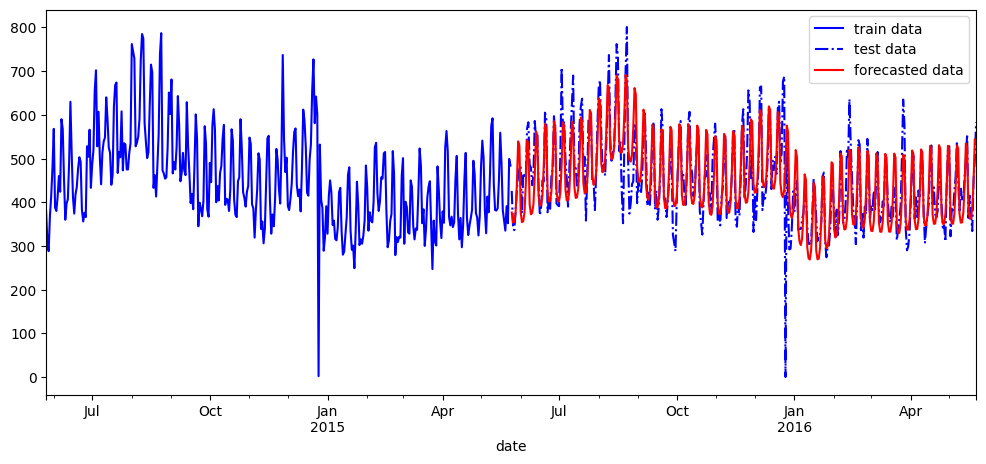

In [282]:
import logging
#logger = logging.getLogger()
#logger.handlers = []
#logger.setLevel(logging.CRITICAL)
logging.disable(logging.CRITICAL)

favg = forecast(ForecastProphet(), train_wf_agg, test_wf_agg)
plot_forecast(train_agg, test_agg, favg)

In [283]:
favg = forecast(ForecastGrp(ForecastProphet()), train_wf, test_wf)
evaluate(test, favg)

wMAPE = 0.19679166076721108
wBIAS = -0.013045719008732262


### Include holidays to Prophet model

In [118]:
df_agg[df_agg<10]

date
2011-12-25    6
2012-12-25    1
2013-12-25    6
2014-12-25    2
2015-12-25    0
Name: quantity, dtype: int64

In [287]:
christmas = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2010-12-25', '2011-12-25', '2012-12-25',
                        '2013-12-25', '2014-12-25', '2015-12-25',
                        '2016-12-25', '2017-12-25']),
})

In [288]:
class ForecastProphetH:
    
    def fit(self, train):
        self.model = Prophet(holidays=christmas)
        train_pr = train.reset_index()
        train_pr.columns = ['ds', 'y']
        self.model.fit(train_pr)
        
    def forecast(self, test):
        fdata = self.model.make_future_dataframe(periods=len(test))
        fc_prophet = self.model.predict(fdata)
        return pd.Series(fc_prophet.tail(len(test))['yhat'].values, test.index)

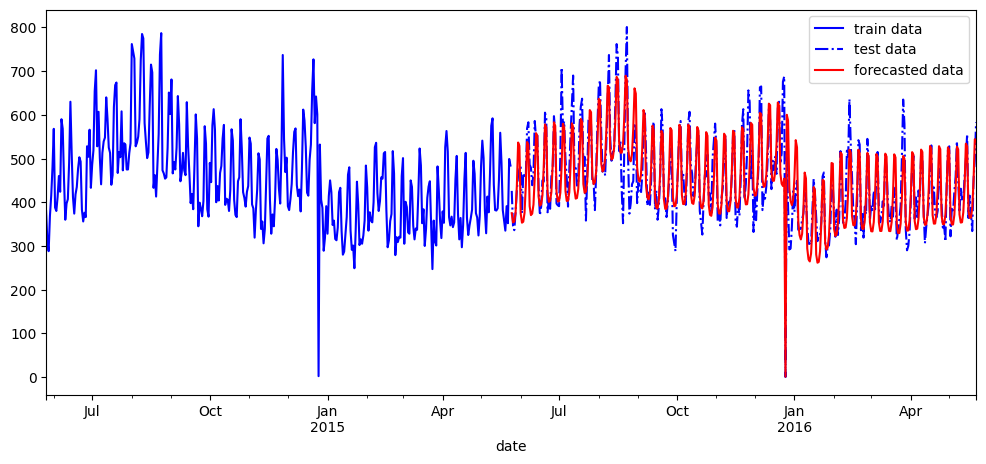

In [289]:
favg = forecast(ForecastProphetH(), train_wf_agg, test_wf_agg)
plot_forecast(train_agg, test_agg, favg)

Let's add all holidays provided in data

In [290]:
df_calendar = pd.read_csv('../data/calendar.csv')
df_calendar['date'] = pd.to_datetime(df_calendar['date'])
df_calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [291]:
df_ev_1 = pd.DataFrame({'holiday': 'Event 1', 'ds': df_calendar[~df_calendar['event_name_1'].isna()]['date']})
df_ev_2 = pd.DataFrame({'holiday': 'Event 2', 'ds': df_calendar[~df_calendar['event_name_2'].isna()]['date']})
df_ev_3 = pd.DataFrame({'holiday': 'snap_CA', 'ds': df_calendar[df_calendar['snap_CA'] == 1]['date']})
df_ev_4 = pd.DataFrame({'holiday': 'snap_TX', 'ds': df_calendar[df_calendar['snap_TX'] == 1]['date']})
df_ev_5 = pd.DataFrame({'holiday': 'snap_WI', 'ds': df_calendar[df_calendar['snap_WI'] == 1]['date']})

In [292]:
holidays = pd.concat((christmas, df_ev_1, df_ev_2, df_ev_3, df_ev_4, df_ev_5))

In [293]:
class ForecastProphetH2:
    
    def fit(self, train):
        self.model = Prophet(holidays=holidays)
        train_pr = train.reset_index()
        train_pr.columns = ['ds', 'y']
        self.model.fit(train_pr)
        
    def forecast(self, test):
        fdata = self.model.make_future_dataframe(periods=len(test))
        fc_prophet = self.model.predict(fdata)
        return pd.Series(fc_prophet.tail(len(test))['yhat'].values, test.index)

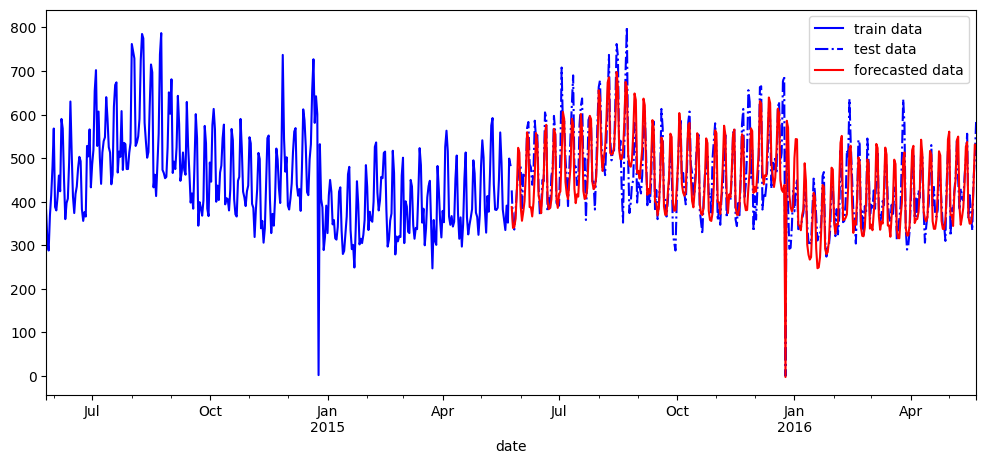

In [294]:
favg = forecast(ForecastProphetH2(), train_wf_agg, test_wf_agg)
plot_forecast(train_agg, test_agg, favg)

In [295]:
favg = forecast(ForecastGrp(ForecastProphetH2()), train_wf, test_wf)
evaluate(test, favg)

wMAPE = 0.19468703368664236
wBIAS = -0.013272795763950972


### Adding regressors to Prophet

In [296]:
df_price = pd.read_csv('../data/sell_prices.csv')
df_price = df_price[df_price.item_id=='FOODS_3_586']
df_price.head()

,store_id,item_id,wm_yr_wk,sell_price
644629,CA_1,FOODS_3_586,11101,1.48
644630,CA_1,FOODS_3_586,11102,1.48
644631,CA_1,FOODS_3_586,11103,1.48
644632,CA_1,FOODS_3_586,11104,1.48
644633,CA_1,FOODS_3_586,11105,1.48


In [297]:
df_merged = pd.merge(df_price.reset_index(), df_calendar[['date', 'wm_yr_wk']], how='inner', on='wm_yr_wk').set_index(['store_id', 'item_id', 'date']).sort_index()
df_merged.head()

index  wm_yr_wk  sell_price
store_id item_id     date                                    
CA_1     FOODS_3_586 2011-01-29  644629     11101        1.48
                     2011-01-30  644629     11101        1.48
                     2011-01-31  644629     11101        1.48
                     2011-02-01  644629     11101        1.48
                     2011-02-02  644629     11101        1.48

In [298]:
df_price_agg = df_merged.groupby('date')['sell_price'].mean()

<Axes: xlabel='date'>

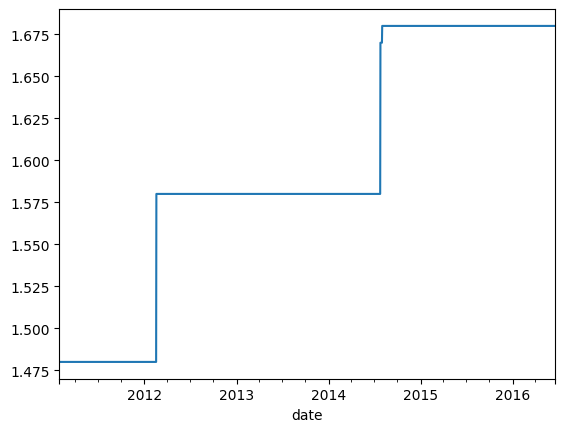

In [301]:
df_price_agg.plot()

In [299]:
class ForecastProphetR:
    def __init__(self, price=None):
        self.price = price
    
    def fit(self, train):
        self.model = Prophet(holidays=holidays)
        self.model.add_regressor('sell_price')
        train_pr = train.reset_index()
        train_pr.columns = ['ds', 'y']
        train_pr = pd.merge(train_pr, self.price, how='inner', left_on='ds', right_index=True)
        self.model.fit(train_pr)
        
    def forecast(self, test):
        fdata = self.model.make_future_dataframe(periods=len(test))
        fdata = pd.merge(fdata, self.price, how='inner', left_on='ds', right_index=True)
        fc_prophet = self.model.predict(fdata)
        return pd.Series(fc_prophet.tail(len(test))['yhat'].values, test.index)

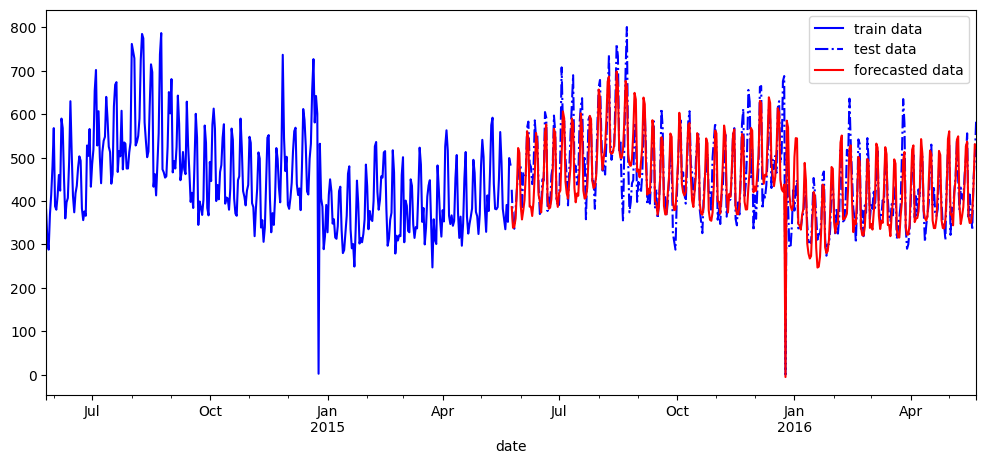

In [300]:
favg = forecast(ForecastProphetR(price=df_price_agg), train_wf_agg, test_wf_agg)
plot_forecast(train_agg, test_agg, favg)

## What next?

There are two other very popular approaches to time series forecasting:
* using standard machine learning methods (with clever feature engineering)
* deep neural networks (RNN - LSTM, transformer-based models)